# Chapter 2: End-to-End Machine Learning Project

## Get the Data

Fetch housing.tgz file from GitHub and save it into the workspace

In [5]:
import os
import tarfile
from six.moves import urllib

DATASETS_URL = "https://github.com/ageron/handson-ml/raw/master/datasets"
HOUSING_PATH = "datasets/housing"
HOUSING_URL = DATASETS_URL + "/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.exists(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    
fetch_housing_data()

Load the data from housing.csv to a Pandas DataFrame

In [6]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, 'housing.csv')
    return pd.read_csv(csv_path)

housing = load_housing_data()

In [7]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [8]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [9]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [10]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


`describe()`

+ count: null values are ignored
+ std: standard deviation
+ 25%, 50%, and 75% (quartiles): percentiles of the variable


<IPython.core.display.Javascript object>


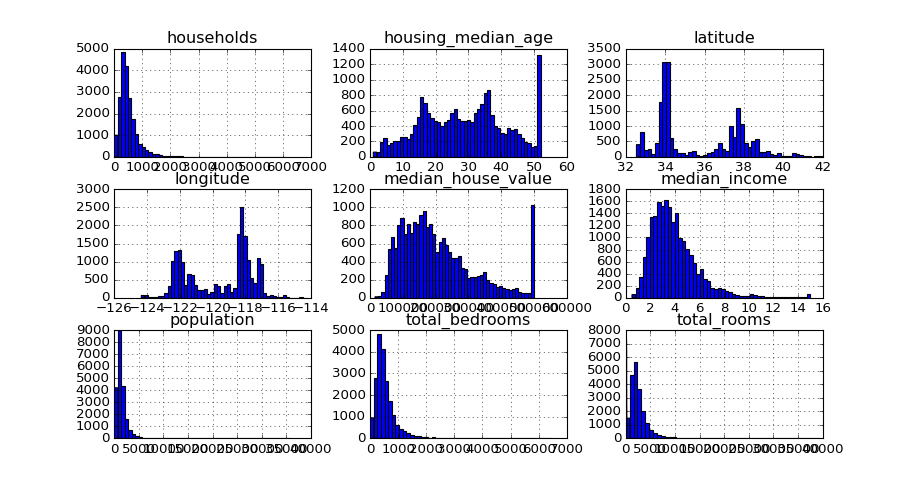

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f09b8f67f28>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f09b5a56978>]], dtype=object)

In [11]:
%matplotlib notebook

import matplotlib.pyplot as plt

housing.hist(bins = 50)

### Create Test Set

_strata_ : division of populations into homogenous groups so that the sampling resembles the overall population.

**Example** :  A survey would try to maintain the ratio of women and men (_strata_ would be sex)

For this dataset, it is assumed that the median income feature is an important attribute. This is why it is important to ensure that the test set is representative of all the categories of incomes in the whole dataset. (_strata_ would be various income categories)

Since the median income is a continuous value, it is necessary to define discrete income categories. The discrete income categories are defined by dividing the `median_income` attribute by 1.5 and rounding up using the ceil function. Also, the categories greater than 5.0 are merged into the 5 category.

<IPython.core.display.Javascript object>


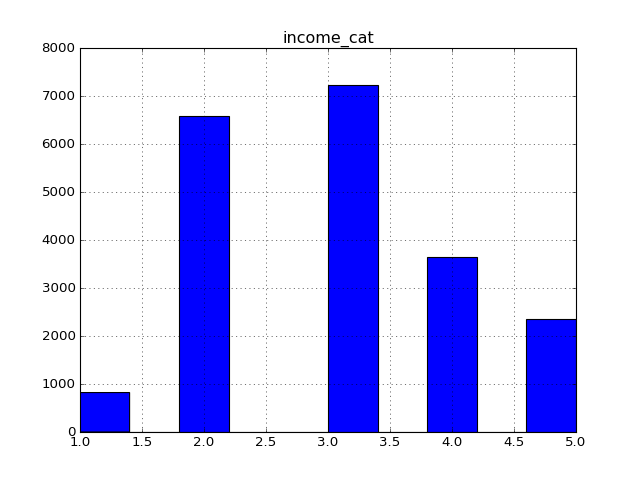

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f09b403e550>]], dtype=object)

In [17]:
import numpy as np
housing['income_cat'] = np.ceil(housing['median_income'] / 1.5)
housing['income_cat'].where(housing['income_cat'] < 5, 5.0, inplace = True)

housing.hist(column='income_cat')

Once the discrete feature is created, the sklearn function StratifiedShuffleSplit class can be used. This class is used to do stratified sampling based on the income category just created.

In [22]:
from sklearn.model_selection import StratifiedShuffleSplit


split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)
for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

** The stratified sampling has income category proportions almost identical to the ones in the dataset, while the test set generated using purely random sampling is skewed. The stratified sampling method is useful for creating test sets respresentative of the full dataset. **

Once the test set is created, the `income_cat` must be deleted to restore the data to its original state.

In [23]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis=1, inplace= True)

## Discover and Visualize the Data to Gain Insights

Create copy of train set to manipulate data without making changes to the actual dataset

In [24]:
housing = strat_train_set.copy()

### Visualizing Geographical Data

+ s: radius of each circle
+ c: color of each circle

<IPython.core.display.Javascript object>


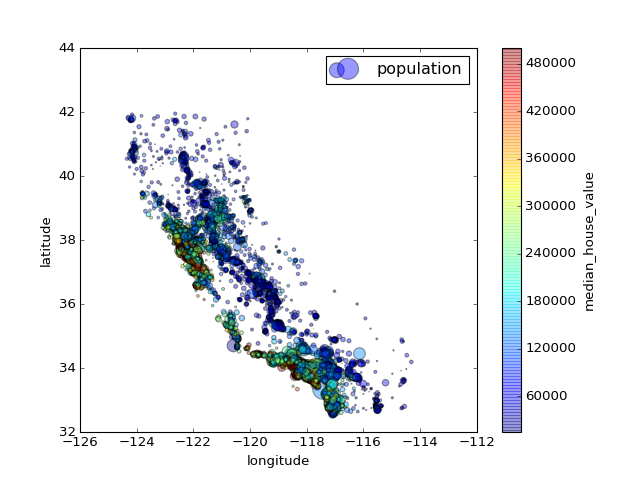

In [27]:
housing.plot(kind = 'scatter', x = 'longitude', y = 'latitude',alpha = 0.4, 
            s= housing['population']/100, label = 'population',
            c = "median_house_value", cmap=plt.get_cmap('jet'), colorbar = True)

### Looking for Correlations

When datasets are not too large, the _standard correlation coeffiecient_ (or _Pearson's r_) between each of the attributes can be calculated. The correlation coefficients range from -1 to 1, where 1 is a strong positive correlation and -1 is a strong negative correlation.

** Take into account:**

+ Correlation coefficients only measures linear correlations. They miss nonlinear relationships
+ Correlation coefficients have nothing to do with the slope of the graph.

In [28]:
corr_matrix = housing.corr()

corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

Another way to check for correlations is the `scatter_matrix` function from Pandas. It is better to focus on the promising attributes since the number of plots is $n^2$, where $n$ is the number of attributes

<IPython.core.display.Javascript object>


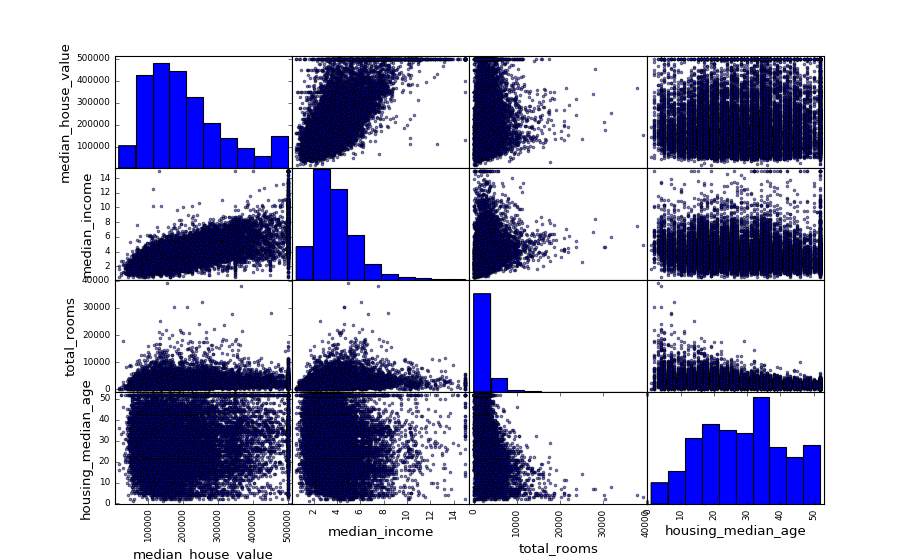

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0994fede80>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f0994ca8710>]], dtype=object)

In [30]:
from pandas.tools.plotting import scatter_matrix

attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(housing[attributes])

The most promising attribute to predict the median house value is the median income, because the points are not too dispersed and a trend can be observed.

<IPython.core.display.Javascript object>


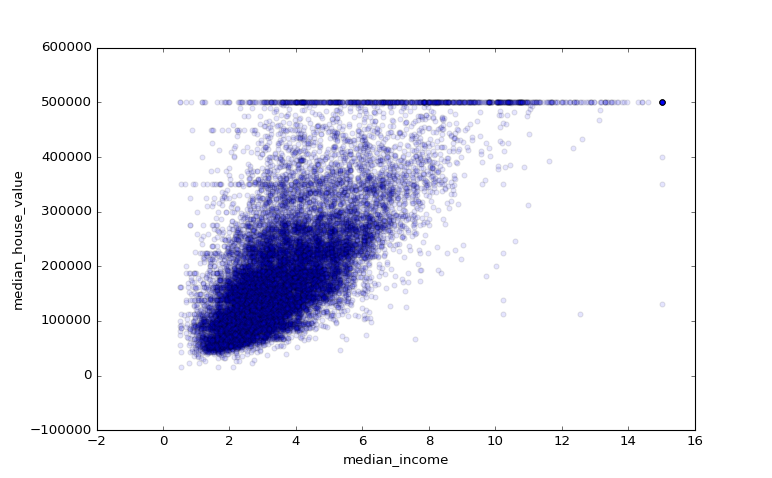

In [31]:
housing.plot(kind='scatter', x ='median_income', y = 'median_house_value', alpha = 0.1)

### Experimenting with Attribute Combinations

Create new attributes to gain further insight from the data. For example, create numbers of rooms per household, bedrooms per room and population per household.

In [32]:
housing['rooms_per_household'] = housing['total_rooms']/housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms']/housing['total_rooms']
housing['population_per_household'] = housing['population']/housing['households']

In [34]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending = False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64